In [1]:
from experiment import db_utils as db
import pandas as pd
import json
from typing import Callable, Dict, Sequence

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# from jupyterthemes import jtplot

# # you can select an alternative theme's plot style by name
# # onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
# jtplot.style('onedork')

In [9]:
# tools for plotting
def multi_line_plot(x_labels: Sequence[str], 
                    data: Sequence[Sequence],
                    line_labels: Sequence[str],
                    y_label: str, 
                    title: str):
    
    xs = np.arange(len(x_labels))  # the label locations
    assert len(data) == len(line_labels)

    fig, ax = plt.subplots(figsize=(8, 7))
    
    lines = []
    for i, (ys, label) in enumerate(zip(data, line_labels)):
        line = ax.plot(xs, ys, label=label)
        lines.append(line)
    

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.set_xticks(xs)
    ax.set_xticklabels(x_labels)
    ax.legend()

    fig.tight_layout()

    plt.show()
    

    
def multi_bar_plot(x_labels: Sequence[str], 
                   data: Sequence[Sequence],
                   category_labels: Sequence[str],
                   bar_y_label: str, 
                   title: str, 
                   category_styles: Dict={},
                   line_y_label: str=None,
                   width: int=0.7, 
                   bar_label_fmt: str='{:.1%}'):
    
    xs = np.arange(len(x_labels))  # the label locations
    assert len(data) == len(category_labels)

    bar_labels = [k for k in category_labels if category_styles.get(k, "bar") == "bar"]
    line_labels = [k for k in category_labels if k in category_styles and category_styles[k] == "line"]
    
    bar_data = [data for data, label in zip(data, category_labels) if label in bar_labels]
    line_data = [data for data, label in zip(data, category_labels) if label in line_labels]

    bar_width = width / len(bar_labels)

    fig, ax = plt.subplots(figsize=(12, 5))
    
    bars = []
    for i, (ys, label) in enumerate(zip(bar_data, bar_labels)):
        bar_positions = xs - width/2 + bar_width * i
        bar = ax.bar(bar_positions, ys, bar_width, label=label, align="edge")
        bars.append(bar)
    
    if not line_y_label:
        lines = []
        for i, (ys, label) in enumerate(zip(line_data, line_labels)):
            color_id = len(bars) + i
            line = ax.plot(xs, ys, color=f"C{color_id}", label=label)

        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax.set_ylabel(bar_y_label)
        ax.set_title(title)
        ax.set_xticks(xs)
        ax.set_xticklabels(x_labels)
        ax.legend()
    else:
        ax.set_ylabel(bar_y_label)
        ax.set_title(title)
        ax.set_xticks(xs)
        ax.set_xticklabels(x_labels)
        ax.legend()
        
        ax2 = ax.twinx()
        lines = []
        for i, (ys, label) in enumerate(zip(line_data, line_labels)):
            color_id = len(bars) + i
            line = ax2.plot(xs, ys, color=f"C{color_id}", label=label)
        y_axis_color = f"C{len(bars)}"
        ax2.set_ylabel(line_y_label, color=y_axis_color)
        ax2.tick_params(axis='y', labelcolor=y_axis_color)
        
        ax2.legend()


    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate(bar_label_fmt.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
    
    for bar in bars:
        autolabel(bar)

    fig.tight_layout()

    plt.show()
    
def stacked_bar_plot(x_labels: Sequence[str], 
                       data: Sequence[Sequence],
                       category_labels: Sequence[str],
                       bar_y_label: str, 
                       title: str, 
                       bar_width: int=0.5, 
                       bar_label_fmt: str='{:.1%}'):
    xs = np.arange(len(x_labels))
    
    fig, ax = plt.subplots(figsize=(12, 5))
    bars = []
    bottom = np.array([0.0 for _ in xs])
    for i, (ys, label) in enumerate(zip(data, category_labels)):
        bar = ax.bar(xs, ys, bar_width, bottom=bottom, label=label)
        bars.append(bar)
        bottom += np.array(ys)
    
    ax.set_ylabel(bar_y_label)
    ax.set_title(title)
    ax.set_xticks(xs)
    ax.set_xticklabels(x_labels)
    ax.legend()
    
    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            x = rect.get_x() + rect.get_width() / 2
            height = rect.get_height()
            y = rect.get_y() + height
            
            ax.annotate(bar_label_fmt.format(height),
                        xy=(x, y),
                        xytext=(0, -13),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
    
    for bar in bars:
        autolabel(bar)

    fig.tight_layout()
    
def multi_stacked_bar_plot(x_labels: Sequence[str],
                           data: Sequence[Sequence],
                           series_labels: Sequence[str],
                           category_labels: Sequence[str],
                           bar_y_label: str, 
                           title: str, 
                           bar_width: int=0.7, 
                           bar_label_fmt: str='{:.1%}'):
    x_range = np.arange(len(x_labels))
    one_bar_width = bar_width / len(data)
    
    fig, ax = plt.subplots(figsize=(12, 5))
    bars = []
    
#     if len(category_labels) == 5:
    colors = ["#5dade2",  "#E74C3C", "#85C1E9", "#F1948A", "#A6ACAF"]

    for i, (series_data, series_label) in enumerate(zip(data, series_labels)):
        xs = x_range - bar_width/2 + one_bar_width * i
        bottom = np.array([0.0 for _ in xs])
        for j, (ys, category_label) in enumerate(zip(series_data, category_labels)):
            if len(category_labels) == 5:
                hatch = "///" if j == 0 or j == 1 else ""
            else:
                hatch = ""
                
            if i == 0:
                bar = ax.bar(xs, ys, one_bar_width-0.05, bottom=bottom, label=category_label, align="edge", hatch=hatch, color=colors[j])
            else:
                bar = ax.bar(xs, ys, one_bar_width-0.05, bottom=bottom, align="edge", hatch=hatch, color=colors[j])
            bars.append(bar)
            bottom += np.array(ys)
    
    ax.set_ylabel(bar_y_label)
    ax.set_title(title)
    ax.set_xticks(x_range)
    ax.set_xticklabels(x_labels)
    ax.legend()
    
    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            x = rect.get_x() + rect.get_width() / 2
            height = rect.get_height()
            y = rect.get_y() + height
            
            ax.annotate(bar_label_fmt.format(height),
                        xy=(x, y),
                        xytext=(0, -13),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
    
    if bar_label_fmt:
        for bar in bars:
            autolabel(bar)

    fig.tight_layout()
    


In [ ]:
# data aggregation

label_remapping = {
    "sentence_q": "Q_Subj",
    "subj_adj": "Adj_Subj",
    "subj_noun": "N_Subj",
    "subj": "NP_Subj", 
    "neg": "Neg",
    "negp": "NegP",
    "v_adv": "Adv",
    "v_verb": "V",
    "v_bar": "VP",
    "vp": "QP_Obj",
    "vp_q": "Q_Obj",
    "obj_adj": "Adj_Obj",
    "obj_noun": "N_Obj",
    "obj": "NP_Obj"
}

def aggregate_by_high_node(rs, col_name: str, aggregate: Callable, scale=1, use_new_labels=True):
    labels = ["sentence_q", "subj_adj", "subj_noun", "subj", "neg", "negp", 
              "v_adv", "v_verb", "v_bar", "vp", "vp_q", 
              "obj_adj", "obj_noun", "obj"]
    labels2idx = {l: i for i, l in enumerate(labels)}
    res = [None] * len(labels)
    
    if aggregate not in {max, min, sum}:
        raise ValueError("Does not support this type of aggregation")
    
    for row in rs:
        abstraction = json.loads(row["abstraction"])
        high_node = abstraction[0]
        low_node = abstraction[1][0]

        i = labels2idx[high_node]
        
        if col_name.endswith("s"):
            values = json.loads(row[col_name])
            value = aggregate(values)
        else:
            value = row[col_name]
            
        value *= scale
        
        if res[i] is None:
            res[i] = value
        else:
            res[i] = aggregate([res[i], value])
    
    for i, x in enumerate(res):
        if x is None:
            res[i] = 0
    labels = [label_remapping[l] for l in labels]
    return labels, res
    
def aggregate_bert_data_by_layer(rs, col_name, high_nodes=None, aggregate=None, scale=1):
    low_nodes = [f"bert_layer_{i}" for i in range(11)]
    low_node_to_idx = {l: i for i, l in enumerate(low_nodes)}
    if high_nodes is None:
        high_nodes = ["sentence_q", "subj_adj", "subj_noun", "subj", "neg", "negp", 
                      "v_adv", "v_verb", "v_bar", "vp", "vp_q", 
                      "obj_adj", "obj_noun", "obj"]
    high_node_to_idx = {l: i for i, l in enumerate(high_nodes)}
    res = [[0] * len(low_nodes) for _ in high_nodes]

    for row in rs:
        abstraction = json.loads(row["abstraction"])
        high_node = abstraction[0]
        low_node = abstraction[1][0]

        if "baseline" in row["model_path"]: continue
        
        idx = high_node_to_idx[high_node]
        if col_name.endswith("s"):
            values = json.loads(row[col_name])
            value = aggregate(values)
        else:
            value = row[col_name]
        
        value *= scale
        
        val_idx = low_node_to_idx[low_node]
        res[idx][val_idx] = value
        
            
    return [f"layer_{i}" for i in range(11)], res, high_nodes

def aggregate_lstm_data(rs, col_name, aggregate=None, scale=1):
    labels = ["sentence_q", "subj_adj", "subj_noun", "subj", "neg", "negp", 
              "v_adv", "v_verb", "v_bar", "vp", "vp_q", 
              "obj_adj", "obj_noun", "obj"]
    labels2idx = {l: i for i, l in enumerate(labels)}
    baseline = [None] * len(labels)
    trained = [None] * len(labels)
    for row in rs:
        abstraction = json.loads(row["abstraction"])
        high_node = abstraction[0]
        is_baseline = "baseline" in row["model_path"]
        i = labels2idx[high_node]
        if col_name.endswith("s"):
            values = json.loads(row[col_name])
            value = aggregate(values)
        else:
            value = row[col_name]
        
        value *= scale
        
        if is_baseline:
            baseline[i] = value if baseline[i] is None else aggregate([baseline[i], value])
        else:
            trained[i] = value if trained[i] is None else aggregate([trained[i], value])
            
    return labels, baseline, trained


def aggregate_data_by_ratio(rows, numerator_cols: Sequence[str], denominator_cols: Sequence[str], aggregate: Callable):
    labels = ["sentence_q", "subj_adj", "subj_noun", "subj", "neg", "negp", 
              "v_adv", "v_verb", "v_bar", "vp", "vp_q", 
              "obj_adj", "obj_noun", "obj"]
    labels2idx = {l: i for i, l in enumerate(labels)}
    res = [None] * len(labels)
    
    if aggregate not in {max, min, sum}:
        raise ValueError("Does not support this type of aggregation")
    
    for row in rows:
        abstraction = json.loads(row["abstraction"])
        high_node = abstraction[0]

        i = labels2idx[high_node]

        numerator_values = sum(np.array(json.loads(row[c])) for c in numerator_cols)
        denominator_values = sum(np.array(json.loads(row[c])) for c in denominator_cols)
        values = [x / y if y != 0 else 0 for x, y in zip(numerator_values, denominator_values)]
        value = aggregate(values)

        
        if res[i] is None:
            res[i] = value
        else:
            res[i] = aggregate(res[i], value)
    
    return labels, res

def max_data_by_normalized_columns(rows, cols, maximizing_cols):
    labels = ["sentence_q", "subj_adj", "subj_noun", "subj", "neg", "negp", 
              "v_adv", "v_verb", "v_bar", "vp", "vp_q", 
              "obj_adj", "obj_noun", "obj"]
    labels2idx = {l: i for i, l in enumerate(labels)}
    cols2idx = {c: i for i, c in enumerate(cols)}
    res = [None] * len(labels)

    for row in rows:
        abstraction = json.loads(row["abstraction"])
        high_node = abstraction[0]
        i = labels2idx[high_node]
        
        totals = sum(np.array(json.loads(row[c])) for c in cols)
        ratios = [np.array(json.loads(row[c])) / totals for c in cols]
        
        # print("totals", totals)
        # print("ratios", ratios)
        
        max_vals = sum(ratios[cols2idx[c]] for c in maximizing_cols)
        argmax_i = np.argmax(max_vals)
        # print("max_vals", max_vals)
        # print("argmax_i", argmax_i)

        max_val = max_vals[argmax_i]
        res_ratios = np.array([r[argmax_i] for r in ratios])
        
        if res[i] is None:
            res[i] = res_ratios
        else:
            orig_max_val = sum(res[i][cols2idx[c]] for c in maximizing_cols)
            if max_val > orig_max_val:
                res[i] = res_ratios
        
    res = [np.array([r[c] for r in res]) for c in range(len(cols))]
    return labels, res
    



In [ ]:
bert_hard_data = db.select("data/interchange/bert-hard.db", "results", cond_dict={"status": 2})
print(f"got {len(bert_hard_data)} rows from bert_hard_data")
lstm_hard_data = db.select("data/interchange/lstm-hard.db", "results", cond_dict={"status": 2})
print(f"got {len(lstm_hard_data)} rows from lstm_hard_data")

bert_easy_data = db.select("data/interchange/bert-easy.db", "results", cond_dict={"status": 2})
print(f"got {len(bert_easy_data)} rows from bert_easy_data")
lstm_easy_data = db.select("data/interchange/lstm-easy.db", "results", cond_dict={"status": 2})
print(f"got {len(lstm_easy_data)} rows from lstm_easy_data")

bert_baseline_data = db.select("data/interchange/bert-baseline.db", "results", cond_dict={"status": 1})
print(f"got {len(bert_baseline_data)} rows from bert_baseline_data")
lstm_baseline_data = db.select("data/interchange/lstm-baseline.db", "results", cond_dict={"status": 2})
print(f"got {len(lstm_baseline_data)} rows from lstm_baseline_data")

# lstm_hard_data = db.select("experiment_data/sep/nov2-500.db", "results", cond_dict={"status": 4}, like={"abstraction": "%lstm_0%"})
# print(len(old_lstm_easy_data))


## Clique sizes

In [ ]:
# Max
labels, lstm_easy_clq_size = aggregate_by_high_node(lstm_easy_data, "max_clique_sizes", aggregate=max, scale=0.001)
_, bert_easy_clq_size = aggregate_by_high_node(bert_easy_data, "max_clique_sizes", aggregate=max, scale=0.001)
_, lstm_baseline_clq_size = aggregate_by_high_node(lstm_baseline_data, "max_clique_sizes", aggregate=max, scale=0.001)


data_for_plot = [lstm_baseline_clq_size, lstm_easy_clq_size, bert_easy_clq_size]
data_labels = ["Baseline", "LSTM", "Bert"]
multi_bar_plot(labels, data_for_plot, data_labels, 
               bar_y_label="Subset size (clique size) as % of examples", 
               title="",
               bar_label_fmt='{:.1%}')

# title="Maximum clique sizes for models trained on the easy dataset"

In [ ]:
# Max
labels, lstm_hard_clq_size = aggregate_by_high_node(lstm_hard_data, "max_clique_sizes", scale=0.001, aggregate=max)
_, bert_hard_clq_size = aggregate_by_high_node(bert_hard_data, "max_clique_sizes", scale=0.001, aggregate=max)
_, lstm_baseline_clq_size = aggregate_by_high_node(lstm_baseline_data, "max_clique_sizes", scale=0.001, aggregate=max)



print(lstm_baseline_clq_size)
print(lstm_hard_clq_size)
print(bert_hard_clq_size)

data_for_plot = [lstm_baseline_clq_size, lstm_hard_clq_size, bert_hard_clq_size]
data_labels = ["Baseline", "LSTM", "Bert"]
multi_bar_plot(labels, data_for_plot, data_labels, 
               bar_y_label="Size as % of examples", 
               title="",
               bar_label_fmt='{:.1%}')

In [ ]:
data_for_plot = [bert_easy_clq_size, bert_hard_clq_size]
data_labels = ["BERT-Easy", "BERT-Hard"]
multi_bar_plot(labels, data_for_plot, data_labels, 
               bar_y_label="Size as % of examples", 
               title="Maximum clique sizes for BERT easy vs hard",
               bar_label_fmt='{:.1%}')

In [ ]:
data_for_plot = [lstm_easy_clq_size, lstm_hard_clq_size]
data_labels = ["LSTM-Easy", "LSTM-Hard"]
multi_bar_plot(labels, data_for_plot, data_labels, 
               bar_y_label="Size as % of examples", 
               title="Maximum clique sizes for LSTM easy vs hard",
               bar_label_fmt='{:.1%}')

In [ ]:
low_nodes, values, high_nodes = arrange_data_by_bert_layer(bert_data, "max_clique_sizes", high_nodes=None, aggregate=max)
multi_line_plot(low_nodes, values, high_nodes, y_label="#successful / #causal", title="Max clique size by bert layer")

## Figure for intervention

<img src="figures/intervention.png">

$$\text{weight}(x, x', V) = \text{Count}^{-1}[V' : y_{V' \leftarrow V'(x')}(x) = y_{V \leftarrow V(x')} (x)] $$

## Schema of interchange experiment

<img src="figures/interchange_experiment.png" >

## Plot by outcome category

<img src="figures/outcome_categories_colored.png" >

In [ ]:
# def get_normalized_column_data(data):
#     all_cols = [f"res_{i}_counts" for i in range(8)]
#     maximizing_cols = ["res_3_counts"]

#     labels, res = max_data_by_normalized_columns(data, all_cols, maximizing_cols)

#     non_causal = sum(res[4:8])

#     data = res[:4] + [non_causal]
#     category_labels = ["!base, !success", "!base, success", "base, !success", "base, success", "non-causal"]
#     return labels, data, category_labels


def get_normalized_column_data(data):
    all_cols = [f"res_{i}_counts" for i in range(8)]
    maximizing_cols = ["res_3_counts"]

    labels, res = max_data_by_normalized_columns(data, all_cols, maximizing_cols)
    
    incorrect = sum([res[0], res[1], res[4], res[5]])

    data = [res[3], res[2], res[7],  res[6], incorrect]
    category_labels = ["causal, successful",  "causal, unsuccessful", "non-causal, successful",  "non-causal, unsuccessful", "base result incorrect"]
    return labels, data, category_labels

In [ ]:
labels, bert_category_data, category_labels = get_normalized_column_data(bert_hard_data)
_, lstm_category_data, _ = get_normalized_column_data(lstm_hard_data)
_, lstm_baseline_category_data, _ = get_normalized_column_data(lstm_baseline_data)
_, bert_baseline_category_data, _ = get_normalized_column_data(bert_baseline_data)
print(bert_baseline_category_data)
print(category_labels)

# stacked_bar_plot(labels, bert_category_data, category_labels, "ratio", "test")
multi_stacked_bar_plot(labels, [bert_baseline_category_data, lstm_category_data, bert_category_data], 
                       ["bert_baseline", "lstm", "bert"], 
                       category_labels, 
                       "ratio", "Breakdown of outcomes of models trained on hard datasets (left to right: LSTM baseline, BERT baseline, LSTM, BERT)", 
                       bar_width=0.7,
                       bar_label_fmt="")

In [ ]:
labels, bert_category_data, category_labels = get_normalized_column_data(bert_easy_data)
_, lstm_category_data, category_labels = get_normalized_column_data(lstm_easy_data)
_, lstm_baseline_category_data, _ = get_normalized_column_data(lstm_baseline_data)


# stacked_bar_plot(labels, bert_category_data, category_labels, "ratio", "test")
multi_stacked_bar_plot(labels, [lstm_baseline_category_data, lstm_category_data, bert_category_data], 
                       ["baseline", "lstm", "bert"], 
                       category_labels, 
                       "ratio", "Breakdown of outcomes of models trained on easy datasets (left to right: Baseline, LSTM, BERT)", 
                       bar_width=0.7,
                       bar_label_fmt="")

In [ ]:
def get_normalized_causal_column_data(data):
    all_cols = [f"res_{i}_counts" for i in range(8)]
    maximizing_cols = ["res_3_counts"]

    labels, res = max_data_by_normalized_columns(data, all_cols, maximizing_cols)

    total = sum(res[:4])
    
    data = [r / total for r in res]

    category_labels = ["!base_eq, !success", "!base_eq, success", "base_eq, !success", "base_eq, success"]
    return labels, data, category_labels

In [ ]:
labels, bert_category_data, category_labels = get_normalized_causal_column_data(bert_hard_data)
_, lstm_category_data, category_labels = get_normalized_causal_column_data(lstm_hard_data)
_, baseline_category_data, _ = get_normalized_causal_column_data(lstm_baseline_data)


# stacked_bar_plot(labels, bert_category_data, category_labels, "ratio", "test")
multi_stacked_bar_plot(labels, [baseline_category_data, lstm_category_data, bert_category_data], 
                       ["baseline", "lstm", "bert"],
                       category_labels, 
                       "ratio", "Breakdown of CAUSAL outcomes of models trained on hard datasets (left to right: Baseline, LSTM, BERT)", bar_width=0.7, bar_label_fmt="")

In [ ]:
labels, bert_category_data, category_labels = get_normalized_causal_column_data(bert_easy_data)
_, lstm_category_data, category_labels = get_normalized_causal_column_data(lstm_easy_data)
_, baseline_category_data, _ = get_normalized_causal_column_data(lstm_baseline_data)

# stacked_bar_plot(labels, bert_category_data, category_labels, "ratio", "test")
# stacked_bar_plot(labels, bert_category_data, category_labels, "ratio", "test")
multi_stacked_bar_plot(labels, [baseline_category_data, lstm_category_data, bert_category_data], 
                       ["baseline", "lstm", "bert"],
                       category_labels, 
                       "ratio", "Breakdown of CAUSAL outcomes of models trained on hard datasets (left to right: Baseline, LSTM, BERT)", 
                       bar_width=0.7, bar_label_fmt="")

In [ ]:
def plot_ratios(baseline_data, lstm_data, bert_data, numerators, denominators, title):
    numerator_cols = [f"res_{i}_counts" for i in numerators]
    denominator_cols = [f"res_{i}_counts" for i in denominators]

    labels, bert_hard_success_rates = aggregate_data_by_ratio(bert_data, numerator_cols, denominator_cols, max)
    _, lstm_hard_success_rates = aggregate_data_by_ratio(lstm_data, numerator_cols, denominator_cols, max)
    _, lstm_baseline_success_rates = aggregate_data_by_ratio(baseline_data, numerator_cols, denominator_cols, max)
    
    labels = [label_remapping[l] for l in labels]

    data_for_plot = [lstm_hard_success_rates, bert_hard_success_rates]
    data_labels = ["LSTM", "Bert"]
    multi_bar_plot(labels, data_for_plot, data_labels, bar_y_label="success rate", title=title)

## Causal Success Rates

$$\text{Success rate} = \frac{Count[\text{intervention correct, low base output correct, intervention impactful}]}{Count[\text{low base output correct, intervention impactful}]} $$

In [ ]:
plot_rates(lstm_baseline_data, lstm_easy_data, bert_easy_data, [3], [2,3], "Intervention success rate on correct inputs and causal interventions, models trained on easy dataset")

In [ ]:
plot_ratios(lstm_baseline_data, lstm_hard_data, bert_hard_data, [3], [2,3], "Intervention success rate on correct inputs and causal interventions, models trained on hard dataset")

## Non-causal Success Rates

$$\text{Success rate} = \frac{Count[\text{intervention correct, low base output correct, intervention unimpactful}]}{Count[\text{low base output correct, intervention unimpactful}]} $$

In [ ]:
plot_rates(lstm_baseline_data, lstm_easy_data, bert_easy_data, [7], [6,7], "Intervention success rate on correct inputs and causal interventions, models trained on easy dataset")

## Total Success rate

$$\text{Relaxed success rate} = \frac{Count[\text{intervention correct, intervention successful}]}{Count[\text{intervention correct}]} $$

In [ ]:
def plot_relaxed_success_rate(baseline_data, lstm_data, bert_data, title):
    numerator_cols = ["res_3_counts", "res_7_counts"]
    denominator_cols = ["res_3_counts", "res_7_counts", "res_2_counts", "res_6_counts"]
    labels, bert_success_rates = aggregate_data_by_ratio(bert_data, numerator_cols, denominator_cols, max)
    _, lstm_success_rates = aggregate_data_by_ratio(lstm_data, numerator_cols, denominator_cols, max)
    _, baseline_success_rates = aggregate_data_by_ratio(baseline_data, numerator_cols, denominator_cols, max)
    
    labels = [label_remapping[l] for l in labels]

    data_for_plot = [baseline_success_rates, lstm_success_rates, bert_success_rates]
    data_labels = ["Baseline", "LSTM", "Bert"]
    multi_bar_plot(labels, data_for_plot, data_labels, bar_y_label="relaxed success rate", title=title)

In [ ]:
plot_relaxed_success_rate(lstm_baseline_data, lstm_easy_data, bert_easy_data, "Maximum success rate on all inputs, trained on easy dataset")

In [ ]:
plot_relaxed_success_rate(lstm_baseline_data, lstm_hard_data, bert_hard_data, "Maximum success rate on all inputs, trained on hard dataset")

In [ ]:
def plot_success_rate(baseline_data, lstm_data, bert_data, title):
    numerator_cols = ["res_6_counts"]
    denominator_cols = ["res_6_counts", "res_7_counts"]
    labels, bert_success_rates = aggregate_data_by_ratio(bert_data, numerator_cols, denominator_cols, max)
    _, lstm_success_rates = aggregate_data_by_ratio(lstm_data, numerator_cols, denominator_cols, max)
    _, baseline_success_rates = aggregate_data_by_ratio(baseline_data, numerator_cols, denominator_cols, max)

    data_for_plot = [baseline_success_rates, lstm_success_rates, bert_success_rates]
    data_labels = ["Baseline", "LSTM", "Bert"]
    multi_bar_plot(labels, data_for_plot, data_labels, bar_y_label="relaxed success rate", title=title)

In [ ]:
plot_success_rate(lstm_baseline_data, lstm_easy_data, bert_easy_data, "Maximum success rate on all inputs, trained on easy dataset")

In [ ]:
plot_success_rate(lstm_baseline_data, lstm_hard_data, bert_hard_data, "Maximum success rate on all inputs, trained on easy dataset")

## Error base result success rate
$$\text{Error base result success rate} = \frac{Count[\text{intervention correct, low base result incorrect, intervention impactful}]}{Count[\text{low base result incorrect, intervention impactful}]} $$

In [ ]:
def plot_error_base_result_success_rate(baseline_data, lstm_data, bert_data, title):
    numerator_cols = ["res_1_counts"]
    denominator_cols = ["res_0_counts", "res_1_counts"]
    labels, bert_success_rates = aggregate_data_by_ratio(bert_data, numerator_cols, denominator_cols, max)
    _, lstm_success_rates = aggregate_data_by_ratio(lstm_data, numerator_cols, denominator_cols, max)
    _, baseline_success_rates = aggregate_data_by_ratio(baseline_data, numerator_cols, denominator_cols, max)

    data_for_plot = [baseline_success_rates, lstm_success_rates, bert_success_rates]
    data_labels = ["baseline", "LSTM", "Bert"]
    multi_bar_plot(labels, data_for_plot, data_labels, bar_y_label="error base result success rate", title=title)

In [ ]:
plot_error_base_result_success_rate(lstm_baseline_data, lstm_easy_data, bert_easy_data, "Maximum success rate on inputs wrongly classified by model, trained on easy dataset")

In [ ]:
plot_error_base_result_success_rate(lstm_baseline_data, lstm_hard_data, bert_hard_data, "Maximum success rate on inputs wrongly classified by model, trained on hard dataset")

In [ ]:
# labels, bert_baseline_eq_rate, bert_eq_rate, argmax = aggregate_by_high_node(bert_data, "interv_eq_rates", aggregate=max, get_argmax=True)
# _, lstm_baseline_eq_rate, lstm_eq_rate = arrange_lstm_data(lstm_data, "interv_eq_rates", aggregate=max)
# _, _, causal_ratio = aggregate_by_high_node(bert_data, "effective_ratios", aggregate=max, scale=250000)

# data_for_plot = [bert_baseline_eq_rate, lstm_baseline_eq_rate, lstm_eq_rate, bert_eq_rate, causal_ratio]
# data_labels = ["Bert Baseline", "LSTM Baseline", "LSTM", "Bert", "Causal interchanges"]
# category_styles = {"Causal interchanges": "line"}
# multi_bar_plot(labels, data_for_plot, data_labels, 
#                category_styles=category_styles,
#                bar_y_label="#successful / #causal", 
#                line_y_label="#causal (#total is 250000)",
#                title="Maximum intervention success rate among all low-level locations")

## Clique size aggregates

In [ ]:
low_nodes, values, high_nodes = arrange_data_by_bert_layer(bert_data, "avg_clique_sizes", high_nodes=None, aggregate=max)
multi_line_plot(low_nodes, values, high_nodes, y_label="#successful / #causal", title="Average clique size by bert layer")

In [ ]:
# Avg
labels, base_eq_rate, trained_eq_rate = arrange_data(rows, "avg_clique_sizes", aggregate=max, scale=1)
bar_plot(labels, x1=base_eq_rate, x2=trained_eq_rate, x1_label="Baseline", x2_label="Trained", 
         y_label="interv_eq_rate", title="Average clique sizes (max among all intervention locations)")

In [ ]:
# Sum
labels, base_eq_rate, trained_eq_rate = arrange_data(rows, "sum_clique_sizes", aggregate=max, scale=1)
bar_plot(labels, x1=base_eq_rate, x2=trained_eq_rate, x1_label="Baseline", x2_label="Trained", 
         y_label="interv_eq_rate", title="Sum of clique sizes (max among all intervention locations)")

## Max clique sizes, left vs right

In [ ]:
labels, _, left_max_clique = arrange_data(rows, "max_clique_sizes", aggregate=lambda s: s[0], scale=1)
labels, _, right_max_clique = arrange_data(rows, "max_clique_sizes", aggregate=lambda s: s[-1], scale=1)
bar_plot(labels, x1=left_max_clique, x2=right_max_clique, x1_label="Left", x2_label="Right", 
         y_label="Max clique sizes", title="Max clique sizes, left vs right", fmt="{}")

## Causal edge ratios

In [ ]:
labels, _, trained = arrange_data(rows, "causal_edge_ratios", aggregate=max, scale=100)
bar_plot(labels, x1=trained, x1_label="Trained", x1_color="orange",
         y_label="Causal edge ratio %", title="Percentage of edges that are causal within all cliques (max among all intervention locations)")

In [ ]:
labels, _, trained = arrange_data(rows, "max_clique_calusal_edge_ratios", aggregate=max, scale=100)
bar_plot(labels, x1=trained, x1_label="Trained", x1_color="orange",
         y_label="Causal edge ratio %", title="Percentage of edges that are causal within the largest clique (max among all intervention locations)")

In [ ]:
import numpy as np

def get_causal_edge_ratio(rows):
    labels = ["sentence_q", "subj_adj", "subj_noun", "subj", "neg", "negp", 
          "v_adv", "v_verb", "v_bar", "vp", "vp_q", 
          "obj_adj", "obj_noun", "obj"]
    labels2idx = {l: i for i, l in enumerate(labels)}
    trained = [0.0] * len(labels)
    for row in rows:
        abstraction = json.loads(row["abstraction"])
        high_node = abstraction[0]
        is_baseline = "baseline" in row["model_path"]
        if is_baseline: continue
        i = labels2idx[high_node]
        if col_name.endswith("s"):
            values = json.loads(row["max_clique_size"])
            
        else:
            value = row[col_name]
        
        value *= scale
        
        if is_baseline:

        trained[i] = value
            
    return labels, baseline, trained

## Verify and merge lstm-easy data

In [ ]:
# new_lstm_easy_data = db.select("experiment_data/lstm/lstm-easy.db", "results", cond_dict={"status": 1})
# old_lstm_easy_data = db.select("experiment_data/sep/nov2-500.db", "results", cond_dict={"status": 4}, like={"abstraction": "%lstm_0%"})

# numerator_cols = ["res_1_counts", "res_3_counts"]
# denominator_cols = ["res_0_counts", "res_1_counts", "res_2_counts", "res_3_counts"]
# labels, new_lstm_easy_interv_eq_rates = aggregate_lstm_data_by_ratio(new_lstm_easy_data, numerator_cols, denominator_cols, max)
# _, _, old_lstm_easy_interv_eq_rates = aggregate_lstm_data(old_lstm_easy_data, "interv_eq_rates", max)

# print(new_lstm_easy_interv_eq_rates)
# print(old_lstm_easy_interv_eq_rates)

# merge graph data into new lstm_easy

# for row in old_lstm_easy_data:
#     update_dict = {
#         "graph_save_paths": row["graph_save_paths"],
#         "max_clique_sizes": row["max_clique_sizes"],
#         "avg_clique_sizes": row["avg_clique_sizes"],b
#         "sum_clique_sizes": row["sum_clique_sizes"],
#         "clique_counts": row["clique_counts"],
#         "visualize_save_paths": row["visualize_save_paths"]
#     }
#     db.add_cols("experiment_data/lstm/lstm-easy.db", "results", update_dict,)
#     db.update("experiment_data/lstm/lstm-easy.db", "results", update_dict, id=(row["id"]+1)//2)


## Visualize counterfactual training results

In [ ]:
from pprint import pprint

cf_random_raw_res_dict = {
    'runtime': 5224.462694883347, 
    'save_path': 'data/cf-training/test/random_full_interx/interx-res-vp-0519-155812.pt', 
    'mappings': '[{"root": {"root": "::"}, "input": {"input": "::"}, "vp": {"bert_layer_3": "(slice(None, None, None), 0, slice(None, None, None))"}}, {"root": {"root": "::"}, "input": {"input": "::"}, "vp": {"bert_layer_3": "(slice(None, None, None), 8, slice(None, None, None))"}}, {"root": {"root": "::"}, "input": {"input": "::"}, "vp": {"bert_layer_3": "(slice(None, None, None), 9, slice(None, None, None))"}}, {"root": {"root": "::"}, "input": {"input": "::"}, "vp": {"bert_layer_3": "(slice(None, None, None), 10, slice(None, None, None))"}}, {"root": {"root": "::"}, "input": {"input": "::"}, "vp": {"bert_layer_3": "(slice(None, None, None), 13, slice(None, None, None))"}}, {"root": {"root": "::"}, "input": {"input": "::"}, "vp": {"bert_layer_3": "(slice(None, None, None), 21, slice(None, None, None))"}}, {"root": {"root": "::"}, "input": {"input": "::"}, "vp": {"bert_layer_3": "(slice(None, None, None), 22, slice(None, None, None))"}}, {"root": {"root": "::"}, "input": {"input": "::"}, "vp": {"bert_layer_3": "(slice(None, None, None), 23, slice(None, None, None))"}}, {"root": {"root": "::"}, "input": {"input": "::"}, "vp": {"bert_layer_3": "(slice(None, None, None), 26, slice(None, None, None))"}}]', 
    'res_0_counts': '[4214, 3317, 3070, 2819, 3842, 3649, 4284, 4529, 3831]', 
    'res_1_counts': '[3584, 4481, 4728, 4979, 3956, 4149, 3514, 3269, 3967]', 
    'res_2_counts': '[562337, 517031, 339811, 215558, 562337, 510603, 468581, 463949, 562337]', 
    'res_3_counts': '[0, 45306, 222526, 346779, 0, 51734, 93756, 98388, 0]', 
    'res_4_counts': '[2054, 2190, 2085, 1735, 2134, 2090, 1779, 1689, 2161]', 
    'res_5_counts': '[148, 12, 117, 467, 68, 112, 423, 513, 41]', 
    'res_6_counts': '[0, 0, 76029, 122432, 0, 1723, 36169, 26739, 0]', 
    'res_7_counts': '[427663, 427663, 351634, 305231, 427663, 425940, 391494, 400924, 427663]'
}

base_only_raw_res_dict = {
    'runtime': 12833.963781118393, 
    'save_path': 'data/cf-training/test/base_only_interx/interx-res-vp-0519-192907.pt', 
    'mappings': '[{"root": {"root": "::"}, "input": {"input": "::"}, "vp": {"bert_layer_3": "(slice(None, None, None), 0, slice(None, None, None))"}}, {"root": {"root": "::"}, "input": {"input": "::"}, "vp": {"bert_layer_3": "(slice(None, None, None), 8, slice(None, None, None))"}}, {"root": {"root": "::"}, "input": {"input": "::"}, "vp": {"bert_layer_3": "(slice(None, None, None), 9, slice(None, None, None))"}}, {"root": {"root": "::"}, "input": {"input": "::"}, "vp": {"bert_layer_3": "(slice(None, None, None), 10, slice(None, None, None))"}}, {"root": {"root": "::"}, "input": {"input": "::"}, "vp": {"bert_layer_3": "(slice(None, None, None), 13, slice(None, None, None))"}}, {"root": {"root": "::"}, "input": {"input": "::"}, "vp": {"bert_layer_3": "(slice(None, None, None), 21, slice(None, None, None))"}}, {"root": {"root": "::"}, "input": {"input": "::"}, "vp": {"bert_layer_3": "(slice(None, None, None), 22, slice(None, None, None))"}}, {"root": {"root": "::"}, "input": {"input": "::"}, "vp": {"bert_layer_3": "(slice(None, None, None), 23, slice(None, None, None))"}}, {"root": {"root": "::"}, "input": {"input": "::"}, "vp": {"bert_layer_3": "(slice(None, None, None), 26, slice(None, None, None))"}}]', 
    'res_0_counts': '[101669, 100244, 111878, 124176, 100936, 101833, 111627, 120413, 100859]', 
    'res_1_counts': '[242865, 244290, 232656, 220358, 243598, 242701, 232907, 224121, 243675]', 
    'res_2_counts': '[225008, 217268, 211030, 194583, 225554, 219595, 215306, 200031, 225531]', 
    'res_3_counts': '[593, 8333, 14571, 31018, 47, 6006, 10295, 25570, 70]', 
    'res_4_counts': '[115439, 114817, 108440, 99161, 116314, 114544, 109226, 102836, 116321]', 
    'res_5_counts': '[1027, 1649, 8026, 17305, 152, 1922, 7240, 13630, 145]', 
    'res_6_counts': '[278, 3880, 9858, 21924, 47, 1735, 6403, 15985, 57]', 
    'res_7_counts': '[313121, 309519, 303541, 291475, 313352, 311664, 306996, 297414, 313342]'
}

locs = [0, 8, 9, 10, 13, 21, 22, 23, 26]


def load_res_dict(raw_res_dict):
    res_dict = {}
    for k, raw_v in raw_res_dict.items():
        if k not in {"save_path"} and isinstance(raw_v, str):
            v = json.loads(raw_v)
        else:
            v = raw_v
        res_dict[k] = v
    return res_dict

cf_res_dict = load_res_dict(cf_random_raw_res_dict)
base_res_dict = load_res_dict(base_only_raw_res_dict)
# pprint(cf_res_dict)

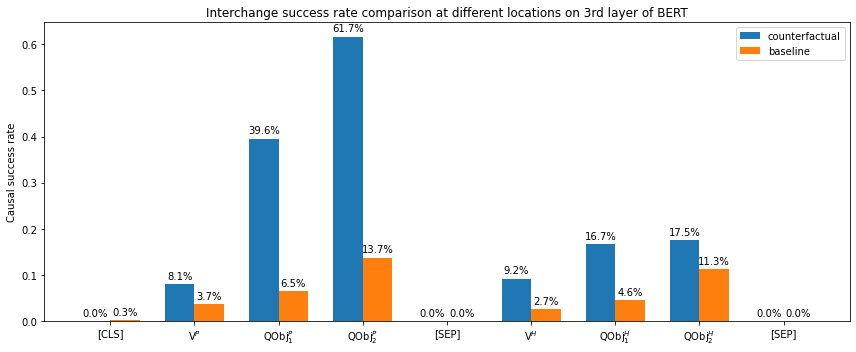

In [16]:

locs = [0, 8, 9, 10, 13, 21, 22, 23, 26]

loc_to_name = ["[CLS]", 
              "QSubj$_1^P$", "QSubj$_2^P$", "AdjSubj$^P$", "NSubj$^P$", "Neg$_1^P$", "Neg$_2^P$", 
               "Adv$^P$", "V$^P$", "QObj$_1^P$", "QObj$_2^P$", "AdjObj$^P$", "NObj$^P$",
              "[SEP]",
              "QSubj$_1^H$", "QSubj$_2^H$", "AdjSubj$^H$", "NSubj$^H$", "Neg$_1^H$", "Neg$_2^H$", 
               "Adv$^H$", "V$^H$", "QObj$_1^H$", "QObj$_2^H$", "AdjObj$^H$", "NObj$^H$",
              "[SEP]"]
x_labels = [loc_to_name[l] for l in locs]

# causal success rate = 3 / (2 + 3)
def get_causal_success_rates(res_dict):
    rates = []
    r2 = res_dict["res_2_counts"]
    r3 = res_dict["res_3_counts"]
    for i in range(len(locs)):
        rates.append(r3[i] / (r2[i] + r3[i]))
    
    return rates

cf_rates = get_causal_success_rates(cf_res_dict)
base_rates = get_causal_success_rates(base_res_dict)

multi_bar_plot(
    x_labels=x_labels, 
    data=[cf_rates, base_rates],
    category_labels=["counterfactual", "baseline"],
    bar_y_label="Causal success rate", 
    title="Interchange success rate comparison at different locations on 3rd layer of BERT", 
    width=0.7, 
    bar_label_fmt='{:.1%}')

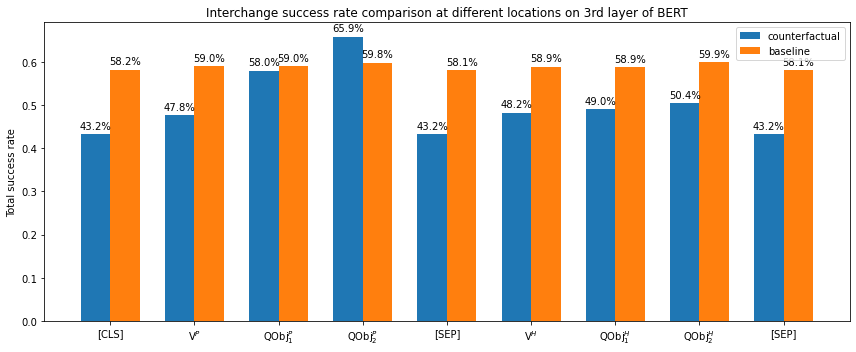

In [17]:
# (3, 7) / (3, 7, 2, 6)
def get_total_success_rates(res_dict):
    rates = []
    r2 = res_dict["res_2_counts"]
    r3 = res_dict["res_3_counts"]
    r6 = res_dict["res_6_counts"]
    r7 = res_dict["res_7_counts"]
    for i in range(len(locs)):
        rates.append((r3[i] + r7[i]) / (r2[i] + r3[i] + r6[i] + r7[i]))
    
    return rates

cf_total_rates = get_total_success_rates(cf_res_dict)
base_total_rates = get_total_success_rates(base_res_dict)

multi_bar_plot(
    x_labels=x_labels, 
    data=[cf_total_rates, base_total_rates],
    category_labels=["counterfactual", "baseline"],
    bar_y_label="Total success rate", 
    title="Interchange success rate comparison at different locations on 3rd layer of BERT", 
    width=0.7, 
    bar_label_fmt='{:.1%}')